In [ ]:
import os 
import glob 
import PIL
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import scipy.io as sio
from random import randrange
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import preprocessing
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Activation, Flatten, Conv1D, Dropout,MaxPooling1D,MaxPool1D
from keras.optimizers import SGD,Adam
from scipy.spatial import distance
import matplotlib.pyplot as plt

# Retrieving data 
data55 = pd.read_excel("/content/drive/My Drive/Neural_Nets_Assignment_2/data55.xlsx", header=None)
data55 = data55.sample(frac=1) # Shuffling

data5 = sio.loadmat('/content/drive/My Drive/Neural_Nets_Assignment_2/data5.mat')
data5 = np.array(data5['x']) # Extracting array from dict
np.random.shuffle(data5) # Shuffling

input = sio.loadmat('/content/drive/MyDrive/Neural_Nets_Assignment_2/input.mat')
input = np.array(input['x'])
input = input.flatten()
input = np.dstack(input)
input = input.T

class_label = sio.loadmat('/content/drive/MyDrive/Neural_Nets_Assignment_2/class_label.mat')
class_label = np.array(class_label['y'])
class_label = np.array([x - 1 for x in class_label])

# Shuffling input and class_label together
rng_state = np.random.get_state()
np.random.shuffle(input)
np.random.set_state(rng_state)
np.random.shuffle(class_label)

# Splits data using hold out cross validation
train_data55, validate_data55, test_data55 = np.split(data55, [int(.7*len(data55)), int(.8*len(data55))]) 
train_data5, validate_data5, test_data5 = np.split(data5, [int(.7*len(data5)), int(.8*len(data5))])

# Split data5 into x and y columns
train_data5_x = train_data5[0:, 0:-1]
train_data5_y = train_data5[0:, -1]
test_data5_x = test_data5[0:, 0:-1]
test_data5_y = test_data5[0:, -1]
validate_data5_x = validate_data5[0:, 0:-1]
validate_data5_y = validate_data5[0:, -1]

train_input, validate_input, test_input = np.split(input, [int(.7*len(input)), int(.8*len(input))])
train_class_label, validate_class_label, test_class_label = np.split(class_label, [int(.7*len(class_label)), int(.8*len(input))])


In [ ]:
#@title Functions and classes used in the questions

class multilayer_Perceptron:
    def __init__(self, x, y):
        self.x = x
        neurons1 = 5
        neurons2 = 28
        self.lr = 1
        ip_dim = x.shape[1]
        op_dim = y.shape[1]

        self.w1 = np.random.randn(ip_dim, neurons1)
        self.b1 = np.zeros((1, neurons1))
        self.w2 = np.random.randn(neurons1, neurons2)
        self.b2 = np.zeros((1, neurons2))
        self.w3 = np.random.randn(neurons2, op_dim)
        self.b3 = np.zeros((1, op_dim))
        self.y = y

    def feedforward(self):
        z1 = np.dot(self.x, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)
        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = sigmoid(z3)
        
    def backprop(self):
        loss = error(self.a3, self.y)
        a3_delta = cross_entropy(self.a3, self.y) 
        z2_delta = np.dot(a3_delta, self.w3.T)
        a2_delta = z2_delta * sigmoid_derv(self.a2) 
        z1_delta = np.dot(a2_delta, self.w2.T)
        a1_delta = z1_delta * sigmoid_derv(self.a1)

        self.w3 -= self.lr * np.dot(self.a2.T, a3_delta)
        self.b3 -= self.lr * np.sum(a3_delta, axis=0, keepdims=True)
        self.w2 -= self.lr * np.dot(self.a1.T, a2_delta)
        self.b2 -= self.lr * np.sum(a2_delta, axis=0)
        self.w1 -= self.lr * np.dot(self.x.T, a1_delta)
        self.b1 -= self.lr * np.sum(a1_delta, axis=0)

    def predict(self, data):
        self.x = data
        self.feedforward()
        return (self.a3>0.5)*1
			
def stat_measures(confusion):
    accuracy = (confusion[0][0] + confusion[1][1]) / (np.sum(confusion))
    sensitivity = confusion[0][0] / (confusion[1][1] + confusion[1][0])
    specificity = confusion[1][1] / (confusion[1][1] + confusion[0][1])
    print("Accuracy is %d" % accuracy)
    print("Specificity is %d" % specificity)
    print("Sensitivity is %d" % sensitivity)

def hypothesis(a):
    #if -a > np.log(np.finfo(type(a)).max):
        #return 0.0    
    return (1. / (1. + np.exp(-a)))

def cross_validation_split(dataset, folds=5):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / folds)
	for i in range(folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

def polynomial_kernel_function(u, v, d):
    return (np.dot(u, v) + 1) ** d

def rbf_kernel_function(u, v, s=1):
    return np.exp(-np.linalg.norm(u - v) / (2 * (s ** 2)))

def gaussian_function(x1, x2, sigma=1):
  return np.exp(- (np.linalg.norm(x1 - x2, 2)) ** 2 / (2 * sigma ** 2))

def create_one_hot_encoding(classes, shape):
    one_hot_encoding = np.zeros(shape)
    for i in range(0, len(one_hot_encoding)):
        one_hot_encoding[i][int(classes[i])] = 1
    return one_hot_encoding

def kmeans(X,k,max_iterations=100):
    if isinstance(X, pd.DataFrame):X = X.values
    idx = np.random.choice(len(X), k, replace=False)
    centroids = X[idx, :]
    P = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([X[P==i,:].mean(axis=0) for i in range(k)])
        tmp = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
        if np.array_equal(P,tmp):break
        P = tmp
    return centroids

def kfold(z,i):
    data=z.copy()
    test=z[i]
    del data[i]
    train=np.concatenate(data)
    return train,test

def l_h_comp(C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))

def hypothesis_derivative(x):
    return x * (1 - x)

def backpropogation1(w1, X_vector, w2, hidden_layer1, w3, hidden_layer2, output_weights, hidden_layer3, y_actual, class_label, learning_rate):
    
    input_vector_with_bias = np.hstack((1, X_vector))
    gradient = (((((((((-2*(y_actual-class_label)*hypothesis_derivative(class_label)*output_weights[1:
]*hypothesis_derivative(hidden_layer3[:,np.newaxis])).T.dot(w3[1:].T)).T)*hypothesis_derivative(hidden_layer2[:,np.newaxis])).T).dot(w2[1:].T)).T)*hypothesis_derivative(hidden_layer1[:,np.newaxis])).dot(
input_vector_with_bias[:,np.newaxis].T))
    w1 = w1-learning_rate*gradient.T
    return w1

def backpropogation2(w2, hidden_layer1, w3, hidden_layer2, output_weights, hidden_layer3, y_actual, class_label, learning_rate):
        
    hidden_layer_with_bias = np.hstack((1, hidden_layer1))
    gradient = ((((-2*(y_actual-class_label)*hypothesis_derivative(class_label)*output_weights[1:]*hypothesis_derivative(hidden_layer3[:,np.newaxis])).T.dot(w3[1:].T)).T)*hypothesis_derivative(hidden_layer2[:,np.newaxis])).dot(hidden_layer_with_bias[:,np.newaxis].T)
    w2 = w2-learning_rate*gradient.T
    return w2

def backpropogation3(w2, hidden_layer1, output_weights, hidden_layer2, y_actual, class_label, learning_rate):
    hidden_layer1_with_bias = np.hstack((1, hidden_layer1))
    gradient = (-2*(y_actual-class_label)*
                hypothesis_derivative(class_label)*
                output_weights[1:]*
                hypothesis_derivative(hidden_layer2[:,np.newaxis])).dot(hidden_layer1_with_bias[:,np.newaxis].T
                )
    w2=w2-learning_rate*gradient.T
    return w2

def backpropogation4(output_weights, hidden_layer2, y_actual, class_label, learning_rate):
    hidden_layer2_with_bias = np.hstack((1, hidden_layer2))
    gradient = -2*(y_actual-class_label)*hypothesis_derivative(class_label)*hidden_layer2_with_bias

    output_weights = output_weights-learning_rate*gradient[:,np.newaxis]
    
    return output_weights

def forward_propagation(weight_matrix, feature_vector):
    feature_matrix = np.hstack((1, feature_vector))
    return hypothesis(weight_matrix.T.dot(feature_matrix))

def sigmoid(s):
    return 1/(1 + np.exp(-s))

def sigmoid_derv(s):
    return s * (1 - s)

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

def error(pred, real):
    n_samples = real.shape[0]
    #logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(real-pred)/n_samples
    return loss

In [ ]:
#@title Implement non-linear perceptron algorithm for the classification. The dataset (data55.mat) contains 4 features and the last column is the output (class label). You can use hold-out cross- validation (70, 10, and 20%) for the selection of training, validation and test instances. Evaluate accuracy, sensitivity and specificity measures for the evaluation of test instances. (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed)

if __name__ == "__main__":
    weights = [0] * (len(data55.iloc[0]))
    weights[-1] = 1 # extra weight is taken as bias (initialized to 1)
    iterations = 1000
    alpha = 0.05
    
    # Training
    for i in range(iterations):
        gradient = [0] * (len(train_data55.iloc[0]))
        for j in range(len(train_data55[0])):
            activation = np.dot(weights, train_data55.iloc[j]) + weights[-1]
            for k in range(len(weights) - 1):
                gradient[k] += ((hypothesis(activation) - train_data55.iat[j, 4]) * hypothesis(activation) * (1 - hypothesis(activation)) * train_data55.iat[j, k])
            gradient[-1] = (hypothesis(activation) - train_data55.iat[j, 4]) * (hypothesis(activation)) * (1 - hypothesis(activation))
        for k in range(len(weights)):
            weights[k] = weights[k] - alpha * gradient[k]
    print("Weights are %s" % weights)
    
    # Validation
    error = 0
    for j in range(len(validate_data55[0])):
        activation = np.dot(weights, validate_data55.iloc[j]) + weights[-1]
        if (validate_data55.iat[j, 4] != int(np.round(hypothesis(activation)))):
            error += 1
    print("Error in validation set is %d" % (error / len(validate_data55[0])))
    
    # Testing
    confusion_matrix = [[0, 0], [0, 0]]
    for k in range(len(test_data55[0])):
        activation = np.dot(weights, test_data55.iloc[k]) + weights[-1]
        confusion_matrix[test_data55.iat[k, 4]][int(np.round(hypothesis(activation)))] += 1
    print("Confusion matrix is %s" % confusion_matrix)
    stat_measures(confusion_matrix)
        

Weights are [-0.7407271470402489, -2.030111120240188, 2.7909703049418635, 1.2580134100506142, 1.055901891815501]
Error in validation set is 0
Confusion matrix is [[11, 0], [0, 9]]
Accuracy is 1
Specificity is 1
Sensitivity is 1


In [ ]:
#@title The dataset (data5.mat) contains 72 features and the last column is the output (class labels). Design a multilayer perceptron based neural network (two hidden layers) for the classification. You can use both holdout (70, 10, and 20%) and 5-fold cross-validation approaches for evaluating the performance of the classifier (individual accuracy and overall accuracy). You can select the number of hidden neurons of each hidden layer and other MLP parameters using grid-search method. (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed). [Marks=5]
import scipy.io
path = "/content/drive/My Drive/Neural_Nets_Assignment_2/data5.mat"
mat = scipy.io.loadmat(path)
np.random.seed(0)

data = mat['x']
np.random.shuffle(data)       

test_size = int(0.2*data.shape[0])                  
val_size = int(0.1*data.shape[0])

test_data = data[:test_size]                       
val_data = data[test_size:(test_size+val_size)]
train_data = data[(test_size+val_size):]

train_data5_x = train_data[:,:-1]
Y_train = train_data[:,-1]
X_test = test_data[:,:-1]
Y_test = test_data[:,-1]

Y_train = np.reshape(Y_train, (-1, 1))
Y_test = np.reshape(Y_test, (-1, 1))

n = train_data5_x.shape[1]
train_mean = np.zeros(n)
train_std = np.zeros(n)

for j in range(n): 
  train_mean[j] = train_data5_x[:,j].mean()
  train_std[j] = train_data5_x[:,j].std()
  train_data5_x[:,j] = (train_data5_x[:,j]-train_data5_x[:,j].mean())/(train_data5_x[:,j].std())

for j in range(n):                                      
  X_test[:,j] = (X_test[:,j]-train_mean[j])/(train_std[j]) 


model = multilayer_Perceptron(train_data5_x, np.array(Y_train))

epochs = 3000
for x in range(epochs):
    model.feedforward()
    model.backprop()
		
def get_acc(x, y):
    acc = 0
    for xx,yy in zip(x, y):
        s = model.predict(xx)
        if s == yy:
            acc +=1
    return acc/len(x)*100
	
print("Training accuracy : ", get_acc(train_data5_x, np.array(Y_train)))
print("Test accuracy : ", get_acc(X_test, np.array(Y_test)))

Training accuracy :  99.13621262458472
Test accuracy :  92.07459207459208


In [ ]:
#@title Implement kernel perceptron algorithm for the classification. The dataset (data55.mat) contains 4 features and the last column is the output (class label). You can use hold-out cross-validation (70, 10, and 20%) for the selection of training, validation and test instances. Evaluate accuracy, sensitivity and specificity measures for the evaluation of test instances. (You can use RBF, and polynomial kernels). (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed)
# TODO: Implement a user input choice for the kernels

if __name__ == "__main__":
    # Training
    alpha = [0] * len(train_data55) # mistake counter
    iterations = 2 # Converges in 2 iterations
    for i in range(iterations):
        for j in range(len(train_data55)):
            lin_comb = 0
            for k in range(len(train_data55)):
                if (int(train_data55.iat[k, 4]) == 0):
                    # lin_comb += alpha[k] * -1 * polynomial_kernel_function(train_data55.iloc[k][0:-1], train_data55.iloc[j][0:-1], 4)
                    lin_comb += alpha[k] * -1 * rbf_kernel_function(train_data55.iloc[k][0:-1], train_data55.iloc[j][0:-1], 4)
                else:
                    # lin_comb += alpha[k] * 1 * polynomial_kernel_function(train_data55.iloc[k][0:-1], train_data55.iloc[j][0:-1], 4)
                    lin_comb += alpha[k] * 1 * rbf_kernel_function(train_data55.iloc[k][0:-1], train_data55.iloc[j][0:-1], 4)
            y_hat = np.sign(lin_comb)
            # TODO: Refactor below
            if (y_hat == -1):
                y_hat = 0 # As truth label in given data is {0, 1}
            else:
                y_hat = 1
            if (y_hat != int(train_data55.iat[j, 4])):
                alpha[j] += 1

    # Validation
    error = 0
    for i in range(len(validate_data55[0])):
        lin_comb = 0
        for j in range(len(train_data55)):
            if (int(train_data55.iat[j, 4]) == 0):
                # lin_comb += alpha[j] * -1 * polynomial_kernel_function(train_data55.iloc[j][0:-1], test_data55.iloc[i][0:-1], 4)
                lin_comb += alpha[j] * -1 * rbf_kernel_function(train_data55.iloc[j][0:-1], test_data55.iloc[i][0:-1], 4)
            else:
                # lin_comb += alpha[j] * 1 * polynomial_kernel_function(train_data55.iloc[j][0:-1], test_data55.iloc[i][0:-1], 4)
                lin_comb += alpha[j] * 1 * rbf_kernel_function(train_data55.iloc[j][0:-1], test_data55.iloc[i][0:-1], 4)
        y_test = np.sign(lin_comb)
        if (int(validate_data55.iat[i, 4]) != y_test):
            error += 1
    print("Error in validation set is %d" % (error / len(validate_data55[0])))

    # Testing
    confusion_matrix = [[0, 0], [0, 0]]
    for i in range(len(test_data55[0])):
        lin_comb = 0
        for j in range(len(train_data55)):
            if (int(train_data55.iat[j, 4]) == 0):
                # lin_comb += alpha[j] * -1 * polynomial_kernel_function(train_data55.iloc[j][0:-1], test_data55.iloc[i][0:-1], 4)
                lin_comb += alpha[j] * -1 * rbf_kernel_function(train_data55.iloc[j][0:-1], test_data55.iloc[i][0:-1], 4)
            else:
                # lin_comb += alpha[j] * 1 * polynomial_kernel_function(train_data55.iloc[j][0:-1], test_data55.iloc[i][0:-1], 4)
                lin_comb += alpha[j] * 1 * rbf_kernel_function(train_data55.iloc[j][0:-1], test_data55.iloc[i][0:-1], 4)
        y_test = np.sign(lin_comb)
        # TODO: Refactor below
        if (y_test == -1):
            y_test = 0
        else:
            y_test = 1
        confusion_matrix[int(test_data55.iat[i, 4])][y_test] += 1
    print("Confusion matrix is %s" % confusion_matrix)
    stat_measures(confusion_matrix)


Error in validation set is 0
Confusion matrix is [[9, 0], [0, 11]]
Accuracy is 1
Specificity is 1
Sensitivity is 0


In [ ]:
#@title Implement the radial basis function neural network (RBFNN) for the classification problem. You can use Gaussian, multiquadric and linear kernel functions for the implementation. You can use both holdout (70, 10, and 20%) and 5-fold cross-validation approaches for evaluating the performance of the classifier (individual accuracy and overall accuracy). The dataset (data5.mat) contains 72 features and the last column is the output (class labels). (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed). [Marks=5]
def gaussian(x1, sigma=1):
  return np.exp(- (x1) ** 2 / (2 * sigma ** 2))
if __name__ == "__main__":
    # Parameters
    K = 100 # Number of clusters

    # Split the data into input and labels and one hot encode class labels
    train_data5_x = train_data5[0:, 0:-1]
    train_data5_y = create_one_hot_encoding(train_data5[0:, -1], (len(train_data5[0:, -1]), 2))
    validate_data5_x = validate_data5[0:, 0:-1]
    validate_data5_y = create_one_hot_encoding(validate_data5[0:, -1], (len(validate_data5[0:, -1]), 2))
    test_data5_x = test_data5[0:, 0:-1]
    test_data5_y = create_one_hot_encoding(test_data5[0:, -1], (len(test_data5[0:, -1]), 2))
    
    centroids = kmeans(train_data5_x, K)
    hidden_matrix = np.zeros((len(train_data5), len(centroids)))

    # Training
    print("Linear Kernel")
    for i in range(len(train_data5)):
        for j in range(len(centroids)):
            hidden_matrix[i][j] = (np.linalg.norm(train_data5_x[i] - centroids[j])) # Linear Kernel
    
    hidden_matrix = np.linalg.pinv(hidden_matrix)
    weight_matrix = hidden_matrix @ train_data5_y

    # Testing
    hidden_test_matrix = np.zeros((len(test_data5), len(centroids)))
    for i in range(len(test_data5)):
        for j in range(len(centroids)):
            hidden_test_matrix[i][j] = (np.linalg.norm(test_data5_x[i] - centroids[j])) # Linear Kernel
    
    y_pred = hidden_test_matrix @ weight_matrix
    y_pred = np.argmax(y_pred, axis=1)
    test_data5_y = np.argmax(test_data5_y, axis=1)
    print(pd.crosstab(y_pred, test_data5_y))
    print(np.sum(y_pred==test_data5_y)/len(test_data5_y))
    
    

Linear Kernel
col_0    0    1
row_0          
0      178   14
1       38  200
0.8790697674418605


In [ ]:
#@title Implement the stacked autoencoder based deep neural network for the classification problem. The deep neural network must contain 3 hidden layers from three autoencoders. You can use holdout (70, 10, and 20%) cross-validation technique for selecting, training and test instances for the classifier. The dataset (data5.mat) contains 72 features and the last column is the output (class labels). For autoencoder implementation, please use back propagation algorithm which has been already taught in the class. Evaluate individual accuracy and overall accuracy. (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed) [Marks=5]
from sklearn.metrics import accuracy_score, confusion_matrix
test = sio.loadmat('/content/drive/My Drive/Neural_Nets_Assignment_2/data5.mat') #importing and loading the data
df=test['x']

def layer(number_of_neurons, number_of_features):
    return 2 * np.random.random((number_of_features + 1, number_of_neurons)) - 1

def weights_init(X_train, y_train, X_test, y_test, learning_rate, hiddenlayer1, hiddenlayer2,hiddenlayer3):
    w1 = layer(hiddenlayer1, X_train.shape[1])
    w2 = layer(hiddenlayer2, hiddenlayer1)
    w3 = layer(hiddenlayer3, hiddenlayer2)
    output_weights = layer(1, hiddenlayer3)
    return w1, w2, w3, output_weights

def train(X_train, y_train, X_test, y_test, learning_rate, hiddenlayer1, hiddenlayer2, hiddenlayer3):

    w1, w2, w3, output_weights = weights_init(X_train, y_train, X_test, y_test, learning_rate, hiddenlayer1, hiddenlayer2, hiddenlayer3)
    alpha = 0.01
    iterations = 30
    for iterations in range(iterations):
        for i in range(X_train.shape[0]):
            X_vector = X_train[i]
            y_actual = y_train[i]
            hidden_layer1 = forward_propagation(w1, X_vector)
            hidden_layer2 = forward_propagation(w2, hidden_layer1)
            hidden_layer3 = forward_propagation(w3, hidden_layer2)
            class_label = forward_propagation(output_weights, hidden_layer3)
            output_weights = backpropogation4(output_weights, hidden_layer3, y_actual, class_label, learning_rate)

            w3 = backpropogation3(w3, hidden_layer2, output_weights, hidden_layer3, y_actual, class_label, learning_rate)

            w2 = backpropogation2(w2, hidden_layer1, w3, hidden_layer2, output_weights,hidden_layer3, y_actual, class_label, learning_rate)

            w1 = backpropogation1(w1, X_vector, w2, hidden_layer1, w3, hidden_layer2,output_weights, hidden_layer3, y_actual, class_label, learning_rate)
    y_pred = []

    for j in range(X_test.shape[0]):
        X_vector = X_test[j]
        hidden_layer1 = forward_propagation(w1, X_vector)
        hidden_layer2 = forward_propagation(w2, hidden_layer1)
        hidden_layer3 = forward_propagation(w3, hidden_layer2)
        prediction = forward_propagation(output_weights, hidden_layer3)
        y_pred.append(prediction)
        
    y_pred = np.squeeze(np.array(y_pred))
    y_class_prediction = np.where(y_pred>0.5, 1, 0)
    accuracy = accuracy_score(y_class_prediction, y_test)
    
    print("ACCURACY IS ", accuracy)
    
    print("CONFUSION MATRIX IS ")
    print(confusion_matrix(y_class_prediction, y_test))
    
    return accuracy



if __name__ == '__main__':
    mat = sio.loadmat('/content/drive/My Drive/Neural_Nets_Assignment_2/data5.mat')
    dataset = pd.DataFrame(mat['x']).sample(frac=1).reset_index(drop=True)

    #Parameters
    learning_rate = 0.01
    # Number of neurons
    hiddenlayer1 = 400
    hiddenlayer2 = 200
    hiddenlayer3 = 400

    # Split and normalize
    train_data_5_x=dataset.iloc[:,:72].values
    X_normalized = (train_data_5_x-train_data_5_x.mean(0))/train_data_5_x[:,0].std(0)
    y=dataset.iloc[:,72].values.astype(int)
    
    split=int(np.round(0.6*X_normalized.shape[0]))
    X_train=X_normalized[:split,:]
    X_test=X_normalized[split:]
    
    y_train=y[:split]
    y_test=y[split:]

    train(X_train, y_train, X_test, y_test, learning_rate, hiddenlayer1, hiddenlayer2, hiddenlayer3)


ACCURACY IS  0.930151338766007
CONFUSION MATRIX IS 
[[375  24]
 [ 36 424]]


In [ ]:
#@title Implement extreme learning machine (ELM) classifier for the classification. You can use Gaussian and tanh activation functions. Please select the training and test instances using 5-fold cross-validation technique Evaluate individual accuracy and overall accuracy. The dataset (data5.mat) contains 72 features and the last column is the output (class labels). (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed) [Marks=5]

def kfold(z,i):
    data=z.copy()
    test=z[i]
    del data[i]
    train=np.concatenate(data)
    return train,test

def tanh(X):
  return np.tanh(X)

def gaussian(x1, sigma=1):
  return np.exp(- (x1) ** 2 / (2 * sigma ** 2))

# Parameters
n_hidden_neurons = 300

train_data5_x = train_data5[0:, 0:-1]
train_data5_y = create_one_hot_encoding(train_data5[0:, -1], (len(train_data5[0:, -1]), 2))
validate_data5_x = validate_data5[0:, 0:-1]
validate_data5_y = create_one_hot_encoding(validate_data5[0:, -1], (len(validate_data5[0:, -1]), 2))
test_data5_x = test_data5[0:, 0:-1]
test_data5_y = create_one_hot_encoding(test_data5[0:, -1], (len(test_data5[0:, -1]), 2))

split = np.array_split(data5, 5)

print("FOR tanh activation")
for i in range(5):
    print("Fold ", i + 1)
    train, test = kfold(split, i)
    train_data5_x = train[:,:72]
    train_data5_y = create_one_hot_encoding(train[:, 72], (len(train[:, 72]), 2))
    test_data5_x = test[:,:72]
    test_data5_y = create_one_hot_encoding(test[:, 72], (len(test[:, 72]), 2))

    randommat = np.random.randn(train_data5_x.shape[1] + 1, n_hidden_neurons)
    tempH = np.append(np.ones((train_data5_x.shape[0], 1)), train_data5_x, axis=1) @ randommat;
    H = tanh(tempH)
    OutputWeight = np.linalg.pinv(H) @ train_data5_y

    testH = np.append(np.ones((test_data5_x.shape[0], 1)), test_data5_x, axis=1) @ randommat;
    Ht = tanh(testH)
    y_pred = Ht @ OutputWeight

    y_pred = np.argmax(y_pred, axis=1)
    test_data5_y = np.argmax(test_data5_y, axis=1)
    print(pd.crosstab(y_pred, test_data5_y))
    print(np.sum(y_pred==test_data5_y)/len(test_data5_y))

print("FOR gaussian activation")
for i in range(5):
    print("Fold ", i + 1)
    train, test = kfold(split, i)
    train_data5_x = train[:,:72]
    train_data5_y = create_one_hot_encoding(train[:, 72], (len(train[:, 72]), 2))
    test_data5_x = test[:,:72]
    test_data5_y = create_one_hot_encoding(test[:, 72], (len(test[:, 72]), 2))

    randommat = np.random.randn(train_data5_x.shape[1] + 1, n_hidden_neurons)
    tempH = np.append(np.ones((train_data5_x.shape[0], 1)), train_data5_x, axis=1) @ randommat
    H = gaussian(tempH)
    OutputWeight = np.linalg.pinv(H) @ train_data5_y

    testH = np.append(np.ones((test_data5_x.shape[0], 1)), test_data5_x, axis=1) @ randommat
    Ht = gaussian(testH)
    y_pred = Ht @ OutputWeight

    y_pred = np.argmax(y_pred, axis=1)
    test_data5_y = np.argmax(test_data5_y, axis=1)
    print(pd.crosstab(y_pred, test_data5_y))
    print(np.sum(y_pred==test_data5_y)/len(test_data5_y))


FOR tanh activation
Fold  1
col_0    0    1
row_0          
0      170   23
1       44  193
0.8441860465116279
Fold  2
col_0    0    1
row_0          
0      185   39
1       27  179
0.8465116279069768
Fold  3
col_0    0    1
row_0          
0      184   31
1       29  186
0.8604651162790697
Fold  4
col_0    0    1
row_0          
0      185   23
1       30  191
0.8764568764568764
Fold  5
col_0    0    1
row_0          
0      183   34
1       38  174
0.8321678321678322
FOR gaussian activation
Fold  1
col_0    0    1
row_0          
0      214  213
1        0    3
0.5046511627906977
Fold  2
col_0    0    1
row_0          
0      212  218
0.4930232558139535
Fold  3
col_0    0    1
row_0          
0      211  217
1        2    0
0.4906976744186046
Fold  4
col_0    0    1
row_0          
0      215  212
1        0    2
0.5058275058275058
Fold  5
col_0    0    1
row_0          
0      219  208
1        2    0
0.5104895104895105


In [ ]:
#@title Implement support vector machine (SVM) classifier for the multi-class classification task. You can use one vs one and one vs all multiclass coding methods to create binary SVM models. Implement the SMO algorithm for the evaluation of the training parameters of SVM such as Lagrange multipliers. You can use holdout approach (70, 10, 20%) for evaluating the performance of the classifier. The dataset (data5.mat) contains 72 features and the last column is the output (class labels). Evaluate individual accuracy and overall accuracy. (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed) [Marks=10]
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

train_data5_x = train_data5[0:, 0:-1]
train_data5_y = train_data5[0:, -1]
test_data5_x = test_data5[0:, 0:-1]
test_data5_y = test_data5[0:, -1]
validate_data5_x = validate_data5[0:, 0:-1]
validate_data5_y = validate_data5[0:, -1]

train_data5_x = normalize(train_data5_x)
test_data5_x = normalize(test_data5_x)
train_data5_y = np.where(train_data5_y == 0, -1, 1)
test_data5_y = np.where(test_data5_y == 0, -1, 1)

def update_bias(X, y, w):
  b_tmp = y - np.dot(w.T, X.T)
  return np.mean(b_tmp)

def update_weight(alpha, y, X):
  return np.dot(X.T, np.multiply(alpha, y))

def error(x_k, y_k, w, b):
  return h(x_k, w, b) - y_k

def randint(a, b, z):
  i = z
  while i == z:
        i = rnd.randint(a,b)
  return i

def model(X, y,max_iter=100, C=1.0, epsilon=0.0001):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = gaussian_function # Using gaussian kernel
        count = 0
        while True:
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = randint(0, n-1, j)
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = l_h_comp(C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Weights and bias
                weight = update_weight(alpha, y, X)
                bias = update_bias(X, y, weight)

                # Errors
                E_i = error(x_i, y_i, weight, bias)
                E_j = error(x_j, y_j, weight, bias)

                # Alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)
                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < epsilon:
                break
                
        bias = update_bias(X, y, weight)

        # Support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return weight, bias

weight, bias = model(train_data5_x,train_data5_y)
y_predicted = predict(test_data5_x,weight,bias)

conf_mat = confusion_matrix(test_data5_y, y_predicted)
print("Confusion matrix is :")
print(conf_mat)
accuracy = (conf_mat[0][0] + conf_mat[1][1]) / (conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])
print("Accuracy is :")
print(accuracy)



Confusion matrix is :
[[169  41]
 [ 31 189]]
Accuracy is :
0.8325581395348837


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 794, 20)           1700      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 264, 20)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 258, 60)           8460      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 86, 60)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 86, 60)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 80, 120)           50520     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 74, 120)          

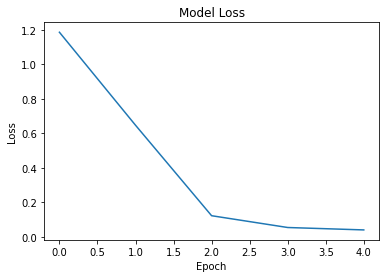

In [ ]:
#@title Implement a multi-channel 1D deep CNN architecture for the seven-class classification task. The input and the class labels are given in .mat file format. There is a total of 17160 number of instances present in both input and class-label data files. The input data for each instance is a multichannel time series (12-channel) with size as (12 ×800). The class label for each multichannel time series instance is given in the class_label.mat file. You can select the training and test instances using hold- out cross-validation (70% training, 10% validation, and 20% testing). The architecture of the multi-channel deep CNN is given as follows. The number of filters, length of each filter, and number of neurons in the fully connected layers are shown in the following figure. Evaluate individual accuracy and overall accuracy. (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are allowed)[Marks=10]
# Training the model
def build_model(train):
    model = Sequential()
    model.add(Conv1D(kernel_size=7, filters=20,activation='relu', input_shape=(800,12)))
    model.add(MaxPooling1D(pool_size=3, strides=3))
    model.add(Conv1D(kernel_size=7,filters=60,activation='relu'))
    model.add(MaxPooling1D(pool_size=3,strides=3))
    model.add(Dropout(0.7))
    model.add(Conv1D(filters=120,kernel_size=7))
    model.add(Conv1D(filters=120,kernel_size=7))
    model.add(Flatten())
    model.add(Dense(2000,activation='relu'))
    model.add(Dense(700,activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(7,activation='sigmoid'))
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_input, train_class_label, epochs=5, batch_size=1000,validation_data=(validate_input, validate_class_label))
    print(history)
    return history, model

if __name__ == "__main__":
    history, model = build_model(train_input)
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    y_pred = np.argmax(model.predict(test_input))
    


In [ ]:
test_class_label=test_class_label+1
y_pred=np.argmax(model.predict(test_input), axis=-1)+1


In [ ]:
test_class_label = test_class_label.T.flatten()

cm=confusion_matrix(test_class_label, y_pred)
print("Confusion matrix is")
cm

Confusion matrix is


array([[549,   0,  37,   0,   0,   0,   0],
       [  0, 388,   0,   0,   0,   0,   0],
       [  0,   0, 555,   0,   0,   0,   0],
       [  0,   0,   0, 307,   0,   0,   0],
       [  0,   0,   0,   0, 601,   0,   0],
       [  0,   0,   0,   0,   0, 621,   0],
       [  0,   0,   0,   0,   0,   0, 374]])

In [ ]:
print("Individual class acc")
cm=confusion_matrix(test_class_label,y_pred)
for i in range(7):
  print("class ", i+1)
  print((cm.diagonal()/cm.sum(axis=1))[i] *100) #Individual Class Accuracy


Individual class acc
class  1
93.68600682593856
class  2
100.0
class  3
100.0
class  4
100.0
class  5
100.0
class  6
100.0
class  7
100.0


In [ ]:
import os 
import glob 
import PIL
import keras 
import tensorflow as tf
import sklearn
import numpy as np
import pandas as pd
import scipy.io as sio 
import matplotlib.pyplot as plt
import warnings 

from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Dropout,MaxPooling2D,MaxPool2D,BatchNormalization
from keras.optimizers import SGD,Adam
from keras.utils import np_utils
from sklearn.utils import shuffle
from PIL import Image

In [ ]:
#@title The two-dimensional time-frequency images of class1, class2, class3 are given in the folders as class1.zip, class2.zip, class3.zip, respectively. Design a 2D deep CNN classifier for the three-class classification. Evaluate the classification performance using hold-out cross-validation (70% training, 10% validation, 20% testing), and 10-fold cross-validation methods. Evaluate individual accuracy and overall accuracy for the multiclass CNN classifier. You can consider 4 convolutional layer, three pooling layer, and 5 fully connected layers. You can select the number of filters, stride for convolution and pooling layers, and number of neurons for fully connected layers as per your own choice. (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are allowed). You can apply dropout, batch normalization, and regularization to improve the classification performance. [Marks=10]
def model_10():
  model = Sequential()
  model.add(Conv2D(filters = 8, kernel_size = (3,3), input_shape=(128, 128, 3), padding = "same"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
  model.add(Activation('relu'))
  
  model.add(Conv2D(filters = 8, kernel_size = (3,3), padding = "same"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
  
  model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "same"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
  model.add(Activation('relu'))
  
  model.add(Conv2D(filters = 32, kernel_size = (3,3), padding ="same"))
  model.add(Flatten())
  
  model.add(Dense(128))
  model.add(Activation('relu'))
  
  model.add(Dense(64))
  model.add(Dropout(0.3))
  model.add(Activation('relu'))
  
  model.add(Dense(32))
  model.add(Activation('relu'))
  
  model.add(Dense(16))
  model.add(Dropout(0.3))
  model.add(Activation('relu'))
  
  model.add(Dense(3))
  model.add(Activation('softmax'))
  return model


images_x = []
y = []
path_of_image = "/content/drive/MyDrive/class1_images.zip (Unzipped Files)/class1_images"  
data_path = os.path.join(path_of_image,'*g') 
files = glob.glob(data_path) 

for f1 in files:
  image_array = np.asarray((Image.open(f1)
  images_x.append(image_array).resize((128,128))))
  y.append(0)
path_of_image = "/content/drive/MyDrive/class2_images.zip (Unzipped Files)/class2_images"  
data_path = os.path.join(path_of_image,'*g') 
files = glob.glob(data_path) 

for f2 in files:
  image_array = np.asarray((Image.open(f2)
  images_x.append().resize((128,128))))
  y.append(1)
path_of_image = "/content/drive/MyDrive/class3_images.zip (Unzipped Files)/class3_images"  
data_path = os.path.join(path_of_image,'*g') 
files = glob.glob(data_path) 

for f3 in files:
  image_array = np.asarray((Image.open(f3)))
  images_x.append().resize((128,128))))
  y.append(2)
images_x = np.asarray(images_x)
y = np.asarray(y)
images_x = images_x/255.0

warnings.filterwarnings("ignore", category=DeprecationWarning)
train_images_x, test_images_x, train_y, test_y = train_test_split(images_x, y, test_size = 2/10, train_size = 8/10,random_state = 0)
train_images_x, valid_images_x, train_y, valid_y = train_test_split(train_images_x, train_y, test_size = 1/8, train_size = 7/8, random_state = 0)

AttributeError: ignored

In [ ]:
model_10_instance=model_10()
model_10_instance.summary()
model_10_instance.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model_10_instance.fit(train_images_x, train_y, epochs=20, batch_size=15,validation_data=(valid_images_x,valid_y),shuffle=False)
print(history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
activation_28 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      2336      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 32)     

In [ ]:
test_y = test_y+1
y_pred = np.argmax(model_10_instance.predict(test_images_x), axis=-1)+1
cm = pd.crosstab(test_y,y_pred)
print("Confusion matrix is")
print(cm)

Confusion matrix is
col_0   1   2   3
row_0            
1      42   0   0
2       0  54   0
3       0   0  48


In [ ]:
print("cross validation ")
print("Individual class accuracy:")
cm=confusion_matrix(test_y,y_pred)
for i in range(3):
  print("Accuracy for class ", i+1)
  print((cm.diagonal()/cm.sum(axis=1))[i] *100) #Individual Class Accuracy
print("Number of correctly predicted class labels are:",np.sum(y_pred==test_y))
print("Total number of class labels are:",len(test_y))
print("Overall Accuracy is:",np.sum(y_pred==test_y)/len(test_y) *100)

cross validation 
Individual class accuracy:
Accuracy for class  1
100.0
Accuracy for class  2
100.0
Accuracy for class  3
100.0
Number of correctly predicted class labels are: 144
Total number of class labels are: 144
Overall Accuracy is: 100.0


In [ ]:
j=1
Xs, ys = shuffle(X, y,random_state=0)
print("10 Fold Cross validation is as follows")
kf = KFold(n_splits=10)
for train,test in kf.split(Xs):
  print("For Fold ",j)
  j += 1
  train_data_5_xx = Xs[train]
  train_data_5_yy = ys[train]
  test_data5_xx = Xs[test]
  test_data5_yy = ys[test]
  tf.compat.v1.disable_eager_execution()
  warnings.filterwarnings("ignore", category=DeprecationWarning)
  y_pred=np.argmax(model_10_instance(train_data_5_xx,train_data_5_yy).predict(test_data5_xx), axis=-1)
  cm=confusion_matrix(test_data5_yy,y_pred)
  print("Confusion matrix is")
  print(cm)
  print("Individual class accuracy is as follows")
  for i in range(3):
    print("Accuracy for class ", i+1)
    print((cm.diagonal()/cm.sum(axis=1))[i] *100)

  print("Number of correctly predicted class labels are: ",np.sum(y_pred==test_data5_yy))
  print("Total number of class labels are:               ",len(test_data5_yy))
  print("Overall Accuracy is:                            ",np.sum(y_pred==test_data5_yy)/len(test_data5_yy) *100)

10 Fold Cross validation is as follows: 

For Fold  1
Confusion matrix is
[[17  1  0]
 [ 0 21  0]
 [ 0  0 33]]
Individual class accuracy is as follows
Accuracy for class  1
94.44444444444444

Accuracy for class  2
100.0

Accuracy for class  3
100.0

Number of correctly predicted class labels are:  71
Total number of class labels are:                72
Overall Accuracy is:                             98.61111111111111

For Fold  2
Confusion matrix is
[[24  0  0]
 [ 0 33  0]
 [ 0  0 15]]
Individual class accuracy is as follows
Accuracy for class  1
100.0

Accuracy for class  2
100.0

Accuracy for class  3
100.0

Number of correctly predicted class labels are:  72
Total number of class labels are:                72
Overall Accuracy is:                             100.0

For Fold  3
Confusion matrix is
[[19  0  0]
 [ 0 31  0]
 [ 0  0 22]]
Individual class accuracy is as follows
Accuracy for class  1
100.0

Accuracy for class  2
100.0

Accuracy for class  3
100.0

Number of correctly predic